In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from pathlib import Path
from src.data_modules.lcl_data_module import LCLDataModule

import matplotlib.pyplot as plt

data_path = Path("../data/processed/historical/train")
stats_path = Path("../data/processed/historical/train")

dm = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=200, n_samples=20000)
dm.setup()

# VAE Module

In [6]:
from src.models.faraday.model import FaradayVAE
import pytorch_lightning as pl

# Find that at batch size 500 is when MPS becomes faster than CPU... But sometimes large batch size hurts convergence..
model = FaradayVAE(class_dim=2, latent_dim=16, learning_rate=0.001, mse_weight=3) # Option to pass in your own encoder architecture in the future
trainer = pl.Trainer(max_epochs=250, accelerator="cpu")
trainer.fit(model, dm)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/shengchai/.local/share/virtualenvs/OpenSynth-EhRIPYd3/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | encoder        | Encoder                 | 201 K  | train
1 | decoder        | Decoder                 | 200 K  | train
2 | reparametriser | ReparametrisationModule | 544    | train
-------------------------------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.609     Total estimated model params size (MB)
/Users/shengchai/.local/share/virtualenvs/OpenSynth-EhRIPYd3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'tr

Epoch 249: 100%|██████████| 100/100 [00:01<00:00, 75.43it/s, v_num=22, total_loss=1.240, mmd_loss=0.018, mse_loss=0.351, quantile_loss=0.871] 

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 100/100 [00:01<00:00, 74.93it/s, v_num=22, total_loss=1.240, mmd_loss=0.018, mse_loss=0.351, quantile_loss=0.871]


# GMM Module

In [8]:
from src.models.faraday.model import FaradayModel
import numpy as np
import torch

In [13]:
full_model = FaradayModel(vae_module=model, n_components=125, max_iter=10000, tol=1e-5)
gmm_dm = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=5000, n_samples=50000)
gmm_dm.setup()
full_model.train_gmm(dm=gmm_dm)
full_model.train_gmm(dm=dm)

Epoch 0:   0%|          | 0/100 [08:47<?, ?it/s]


10it [01:19,  7.96s/it]
100it [00:06, 14.93it/s]


In [14]:
gmm_samples = full_model.sample_gmm(n_samples=10000)

In [15]:
gmm_kwh = gmm_samples[0]
gmm_mth = gmm_samples[1]
gmm_dow = gmm_samples[2]
gmm_reconstruct = dm.reconstruct_kwh(gmm_kwh)
gmm_resconstruct = torch.clip(gmm_reconstruct, min=0)

In [16]:
vae_kwh, vae_mth, vae_dow = next(iter(dm.train_dataloader()))
vae_mth = vae_mth.reshape(len(vae_kwh), 1)
vae_dow = vae_dow.reshape(len(vae_dow), 1)
encoder_inputs = torch.cat([vae_kwh, vae_mth, vae_dow], dim=1)
encoder_outputs = model.encode(encoder_inputs)
decoder_inputs = torch.cat([encoder_outputs, vae_mth, vae_dow], dim=1)
decoder_outputs = model.decode(decoder_inputs)

vae_reconstruct = dm.reconstruct_kwh(decoder_outputs)
vae_reconstruct = torch.clip(vae_reconstruct, min=0)

In [17]:
real_kwh = dm.reconstruct_kwh(vae_kwh)
real_kwh = torch.clip(real_kwh, min=0)

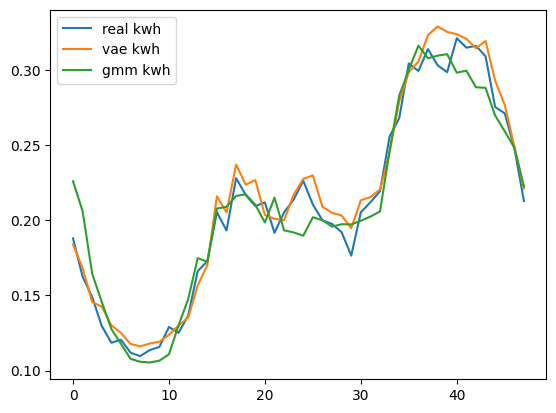

In [18]:
import matplotlib.pyplot as plt

plt.plot(real_kwh.mean(dim=0).detach().numpy(), label="real kwh")

plt.plot(vae_reconstruct.mean(dim=0).detach().numpy(), label="vae kwh")
plt.plot(gmm_resconstruct.mean(dim=0).detach().numpy(), label="gmm kwh")
plt.legend()


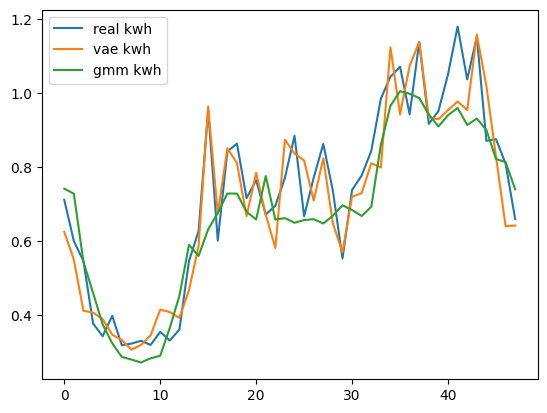

In [19]:
plt.plot(real_kwh.quantile(0.95, dim=0).detach().numpy(), label="real kwh")
plt.plot(vae_reconstruct.quantile(0.95, dim=0).detach().numpy(), label="vae kwh")
plt.plot(gmm_resconstruct.quantile(0.95, dim=0).detach().numpy(), label="gmm kwh")
plt.legend()